# ENGR-E 221 Intelligent Systems I Fall 2023
## Lab 10 Decision Tree Contiued (ensemble methods)

Friday Lab: 11/3/2023 9:45 am - 11:00 am

Friday Lab: 11/3/2023 11:30 am - 12:45 pm


# Face completion with Different Regressors

This example shows the use of multi-output estimator to complete images.
The goal is to predict the lower half of a face given its upper half.

The first column of images shows true faces. The next columns illustrate
how standard decision trees, extremely randomized trees, k nearest neighbors, linear
regression, random forest and ridge regression complete the lower half of those faces.

This code is an adpation of the code found from [scikit-learn docs](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html#sphx-glr-auto-examples-miscellaneous-plot-multioutput-face-completion-py)


This week we will focus around ensemble methods, in particular we will look at the random forest and extra tree regressors. The code below will perform the computations for us and we will then compare the results and discuss the results. Additionally you will see some new python, for example we introduce the use of dictionaries here. 

[Scikit-learn data documentation](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset)

[Description of data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

# it may be helpful to print these off (targets,data) so we can get a handle on the next few lines.

train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Create a small subset to sample this is just for plotting
n_faces = 3
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

n_pixels = data.shape[1]

# Hack this up manually this section should be discussed at the end
# Talking points are what are images made up of?
# What is the shape of this? These figures are 64x64 however fed in as NX4096
# Upper half of the faces

X_train = train[:, : (n_pixels + 1) // 2]
X_test = test[:, : (n_pixels + 1) // 2]

# Lower half of the faces
y_train = train[:, n_pixels // 2 :]
y_test = test[:, n_pixels // 2 :]



print(data.shape)

(400, 4096)


In [2]:
#Here we can look at one of the faces but we need to reshape
# Students need to fille this part in. 
example_face = data[1]
print(example_face)

[0.45454547 0.47107437 0.5123967  ... 0.15289256 0.15289256 0.15289256]


In [3]:
# Fit estimators
ESTIMATORS = {
    "DT": DecisionTreeRegressor(),
    "Extra trees": ExtraTreesRegressor(
        n_estimators=10, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Random Forest": RandomForestRegressor(max_depth=2, random_state=0), 
}

# Lets take the time to discuss the use of a dictionary here and the for loop

y_test_predict = dict()
for name, estimator in ESTIMATORS.items(): # Discuss this we are executing simoultatanously 
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)


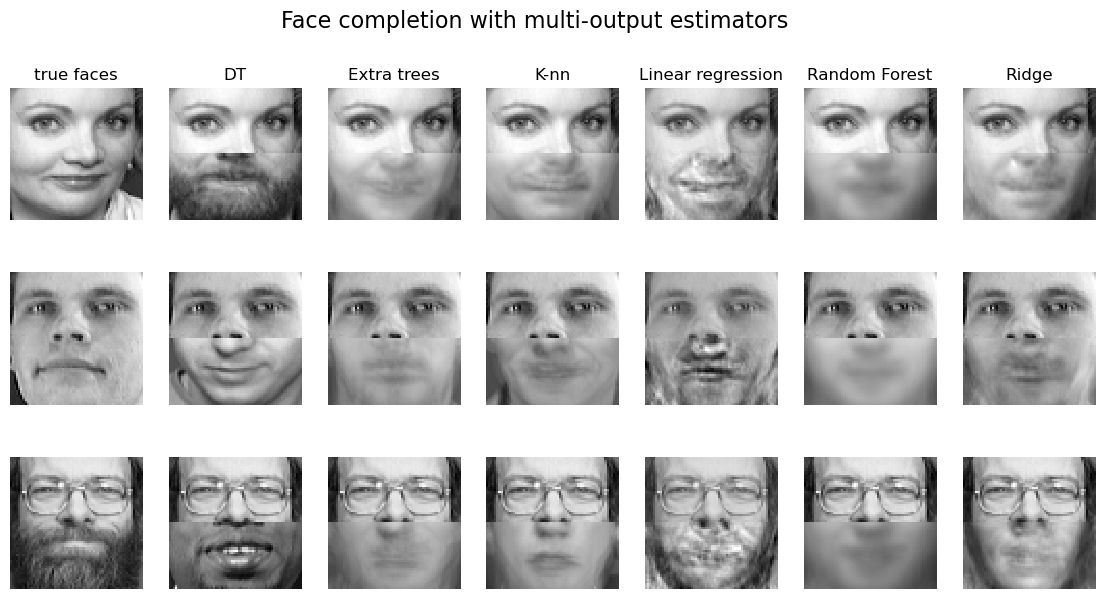

In [4]:
# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        # This bis is important and will be needed for homowork. 
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()

# Task 2 Discussion of Results and Dictionaries (20 min)

1) Where were dictionaries used? 
store different types of models for multiple use

2) Discuss how we split the data
split upper and lower half of face

3) Discuss how these types of models are can/are implemented in the real world?
facial recognition

4) From our real-world implementation discussion can we guess as to why we split the data the way we did?
weaing a mask
5) What is the best regressor for this application? 
random tree


# Group Task (parameter optimization)

For this task we will see which group of students can build the best possible model beween random forest and extra tree regression. 

Split up in to 4 groups. Two groups take random forest and the other two take extra tree. 

[Random Forest Param Opt](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

[Extra Tree Param Opt](https://machinelearningmastery.com/extra-trees-ensemble-with-python/)

Please take the time to look through these articles and take a peak and the sklearn doc [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html). 

We are going to tweak the parameters, think of turning dials on an old AM/FM radio to get the perfect broadcast. We will change the **max_depth**, **max_features**, **min_samples_leaf**, and the **number of estimators**. In our groups we are going to manually change values one at a time for these and evaluate how the accuracy imporves using the supplied function. You can do this with brute force or you can make a loop. The idea here is to inspire you to build the best model as this step can be very time consuming, but doing it a few times showcase the importance of parameter tuning.

In [5]:
# Execute this cell we will use it below.

def evaluate(model, test_features, test_labels):
    test_labels = test_labels + 1
    test_features = test_features + 1
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


In [8]:
# Random Forest
# Students complete 
base_rf =  RandomForestRegressor(max_depth=2, random_state=0) 
base_rf.fit(X_train,y_train)
base_rf_accuracy= evaluate(base_rf, X_test, y_test)

hyper_model_rf = RandomForestRegressor(max_depth=2, max_features=2, min_samples_leaf=3, min_samples_split = 8, n_estimators=100,
                                      random_state=0, bootstrap=True)
hyper_model_rf.fit(X_train, y_train)
hyper_accuracy_rf = evaluate(hyper_model_rf, X_test,y_test)
print('Improvement of {:0.2f}%.'.format(100*(hyper_accuracy_rf - base_rf_accuracy)/base_rf_accuracy))
# train and evaluate

# create a model with some different hyperparameters

#Compare:
#print('Improvement of {:0.2f}%.'.format( 100 * (hyper_accuracy_rf - base_rf_accuracy) / base_rf_accuracy))


Model Performance
Average Error: 0.9126 degrees.
Accuracy = 38.63%.
Model Performance
Average Error: 0.8882 degrees.
Accuracy = 40.29%.
Improvement of 4.30%.


In [ ]:
# Extra Tree
# Students complete
base_et =  ExtraTreesRegressor(n_estimators=10, max_features=32, random_state=0)
#train and evaluate

#create a model with some different hyperparameters
hyper_model_et = 
# train and evaluate

#Compare:
print('Improvement of {:0.2f}%.'.format( 100 * (hyper_accuracy_et - base_et_accuracy) / base_et_accuracy))
